# RA and Dec Coordinate Range to Priors

In [1]:
# importing plotting and locus tools
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import MakePriors as mp

In [2]:
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from getpass import getpass
import pandas as pd
import healpy as hp
import numpy as np

In [3]:
#define global variables
nside=32
min_ra=0
max_ra=2
min_dec=0
max_dec=6

In [4]:
from ListHealpixel import list_healpixel
lh = list_healpixel(nside, min_ra, max_ra, min_dec, max_dec)
pixel_array = lh.pixelsinrange
print(pixel_array)

[5568, 5824]


In [5]:
#create list that holds the nested256_array for each healpixel called 
nested256_arrays = []

# Iterate over the pixel_array
for pixelnumber in pixel_array:
    npixratio = hp.nside2npix(256)/hp.nside2npix(nside)
    start = npixratio * pixelnumber
    stop = start + npixratio
    nested256_array = np.arange(start, stop, 1, dtype=int)
    nested256_arrays.append(nested256_array)

# nested256_arrays now holds the results for each pixelnumber in pixel_array
for i, nested256_array in enumerate(nested256_arrays):
    print(f"Pixel number {pixel_array[i]}: {nested256_array}")

Pixel number 5568: [356352 356353 356354 356355 356356 356357 356358 356359 356360 356361
 356362 356363 356364 356365 356366 356367 356368 356369 356370 356371
 356372 356373 356374 356375 356376 356377 356378 356379 356380 356381
 356382 356383 356384 356385 356386 356387 356388 356389 356390 356391
 356392 356393 356394 356395 356396 356397 356398 356399 356400 356401
 356402 356403 356404 356405 356406 356407 356408 356409 356410 356411
 356412 356413 356414 356415]
Pixel number 5824: [372736 372737 372738 372739 372740 372741 372742 372743 372744 372745
 372746 372747 372748 372749 372750 372751 372752 372753 372754 372755
 372756 372757 372758 372759 372760 372761 372762 372763 372764 372765
 372766 372767 372768 372769 372770 372771 372772 372773 372774 372775
 372776 372777 372778 372779 372780 372781 372782 372783 372784 372785
 372786 372787 372788 372789 372790 372791 372792 372793 372794 372795
 372796 372797 372798 372799]


In [6]:
#convert array from nested to ring healpixel numbering
combined_array = np.concatenate(nested256_arrays)
ring256_array = hp.nest2ring(256, combined_array)

In [7]:
#function to define query with list of healpixels and quantities to retrieve from lsst_sim.simdr2 table at Astro Lab
def makeQueryString(ring256_array):
    query1 = """
    SELECT ra, dec, gall, galb, gc, logage, mass, label, logg, m_h, av, mu0, umag, gmag, rmag, imag, zmag, ymag, nest4096, ring256
    FROM lsst_sim.simdr2
    WHERE"""
    query = query1 + f" ring256 = {ring256_array[0]}"
    for ring in ring256_array[1:]:
        query += f" OR ring256 = {ring}"
    return query + "\n"

querystring = makeQueryString(ring256_array)
print(querystring)


    SELECT ra, dec, gall, galb, gc, logage, mass, label, logg, m_h, av, mu0, umag, gmag, rmag, imag, zmag, ymag, nest4096, ring256
    FROM lsst_sim.simdr2
    WHERE ring256 = 392000 OR ring256 = 390976 OR ring256 = 390975 OR ring256 = 389952 OR ring256 = 389953 OR ring256 = 388929 OR ring256 = 388928 OR ring256 = 387905 OR ring256 = 389951 OR ring256 = 388927 OR ring256 = 388926 OR ring256 = 387903 OR ring256 = 387904 OR ring256 = 386880 OR ring256 = 386879 OR ring256 = 385856 OR ring256 = 387906 OR ring256 = 386882 OR ring256 = 386881 OR ring256 = 385858 OR ring256 = 385859 OR ring256 = 384835 OR ring256 = 384834 OR ring256 = 383811 OR ring256 = 385857 OR ring256 = 384833 OR ring256 = 384832 OR ring256 = 383809 OR ring256 = 383810 OR ring256 = 382786 OR ring256 = 382785 OR ring256 = 381762 OR ring256 = 387902 OR ring256 = 386878 OR ring256 = 386877 OR ring256 = 385854 OR ring256 = 385855 OR ring256 = 384831 OR ring256 = 384830 OR ring256 = 383807 OR ring256 = 385853 OR ring256 = 384

In [8]:
#retrieve patch using MakePriors.py 
nested_patch = mp.retrievePatch(querystring)

querying...
converting...
retrieved patch with 510034  entries


r= 13.5 to 14.5 N= 16321088 Ns= 55552


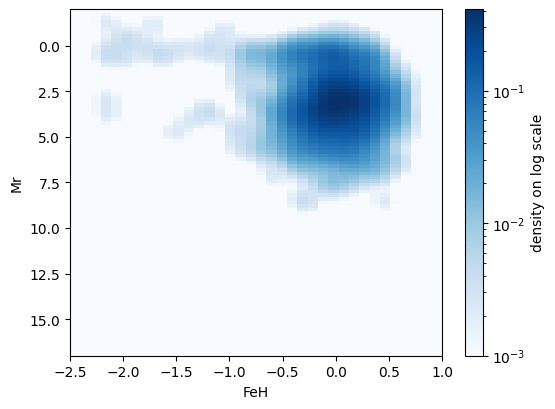

r= 14.0 to 15.0 N= 16321088 Ns= 78272


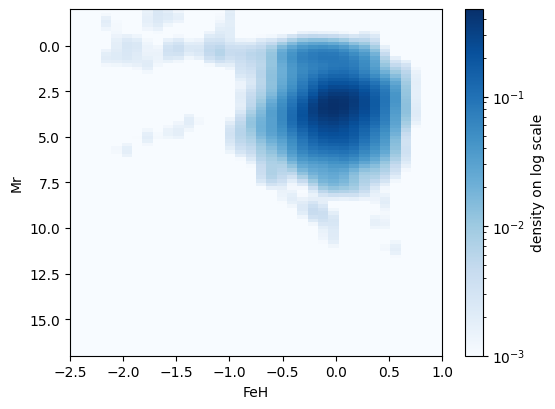

r= 14.5 to 15.5 N= 16321088 Ns= 101568


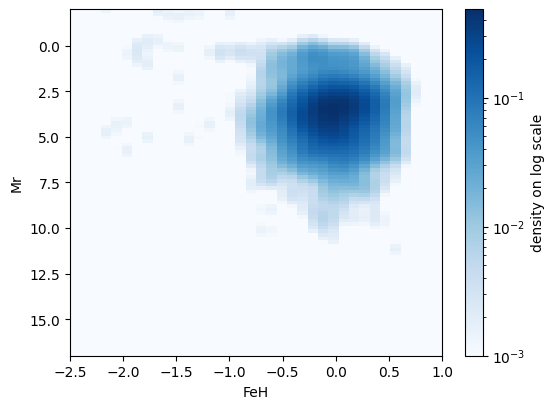

r= 15.0 to 16.0 N= 16321088 Ns= 134432


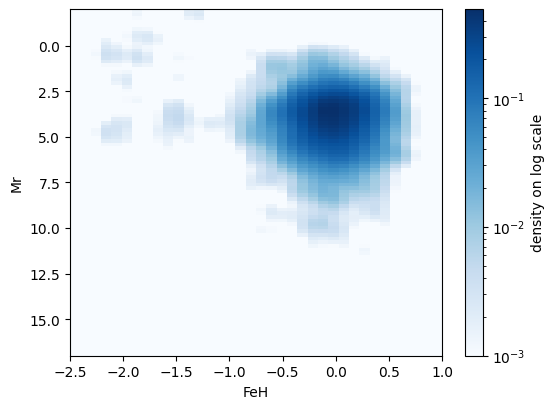

r= 15.5 to 16.5 N= 16321088 Ns= 177120


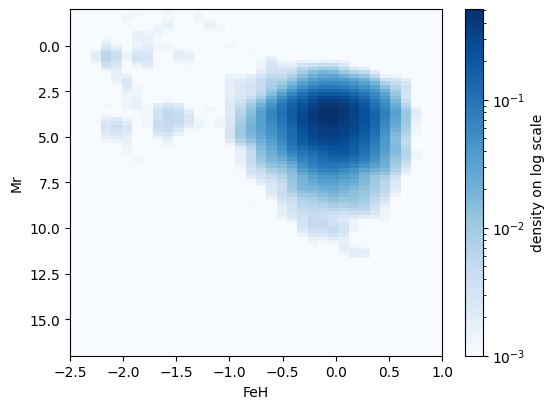

r= 16.0 to 17.0 N= 16321088 Ns= 228864


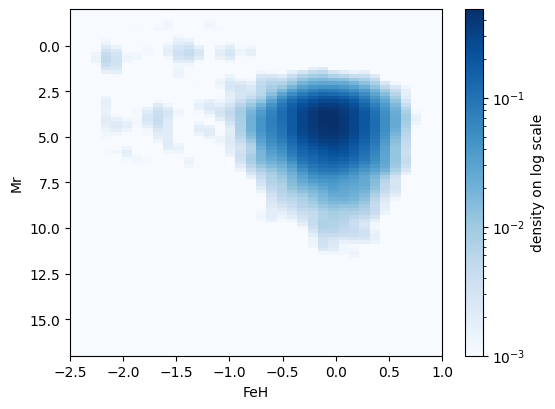

r= 16.5 to 17.5 N= 16321088 Ns= 280512


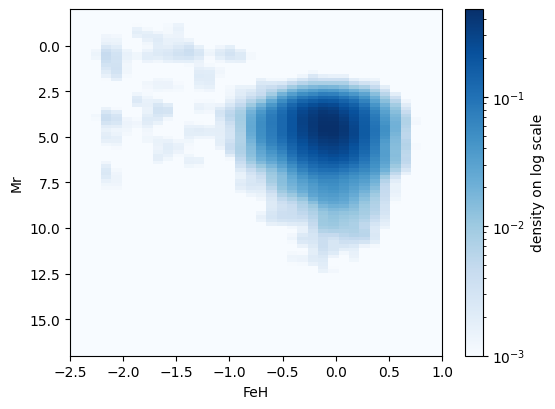

r= 17.0 to 18.0 N= 16321088 Ns= 332480


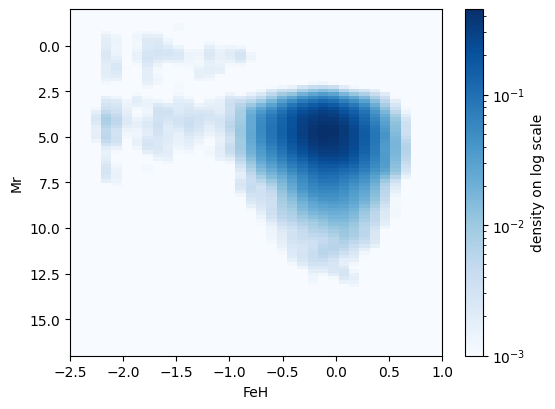

r= 17.5 to 18.5 N= 16321088 Ns= 389312


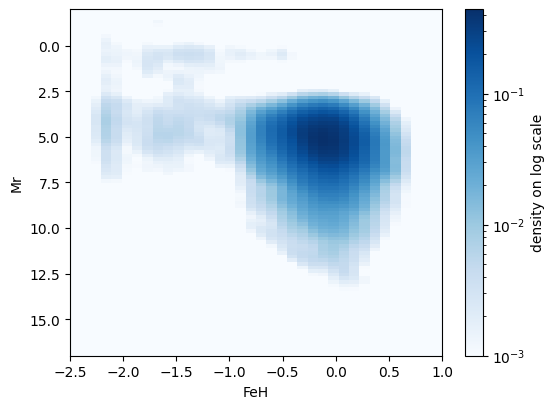

r= 18.0 to 19.0 N= 16321088 Ns= 438208


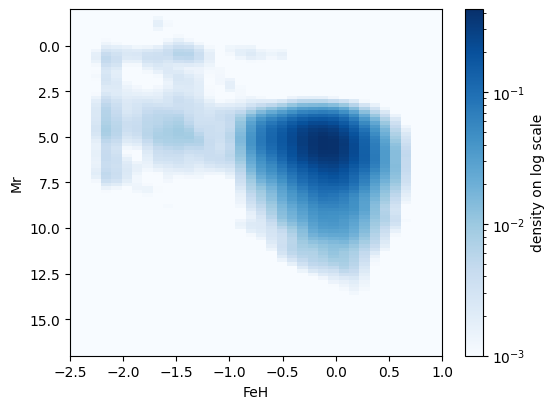

r= 18.5 to 19.5 N= 16321088 Ns= 482816


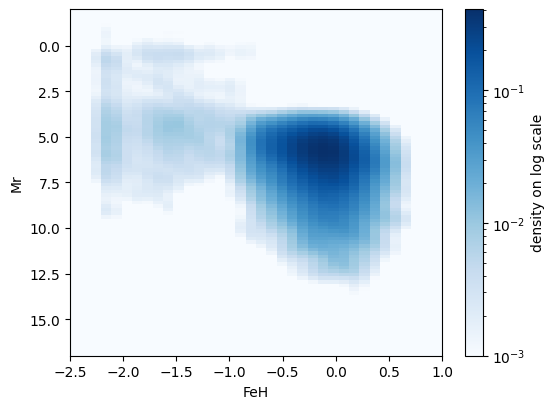

r= 19.0 to 20.0 N= 16321088 Ns= 524032


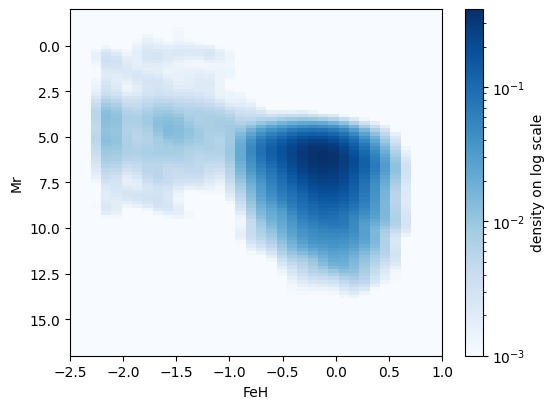

r= 19.5 to 20.5 N= 16321088 Ns= 573920


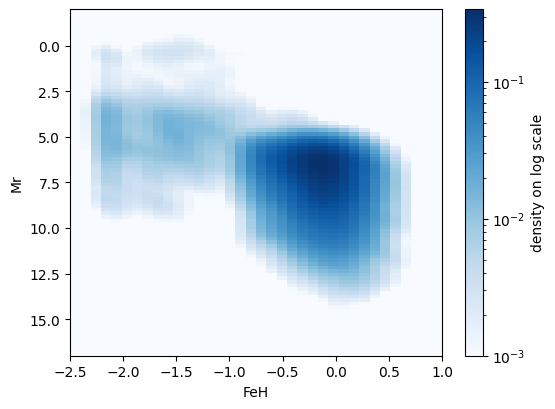

r= 20.0 to 21.0 N= 16321088 Ns= 642592


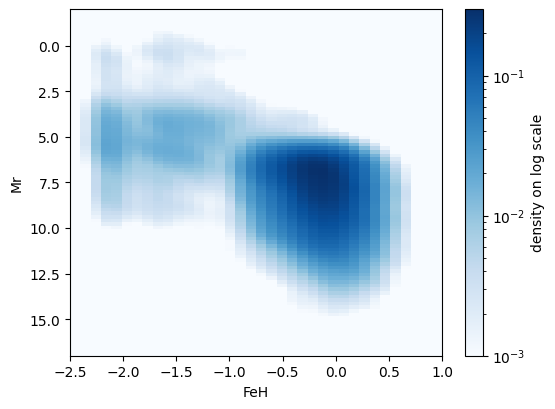

r= 20.5 to 21.5 N= 16321088 Ns= 739040


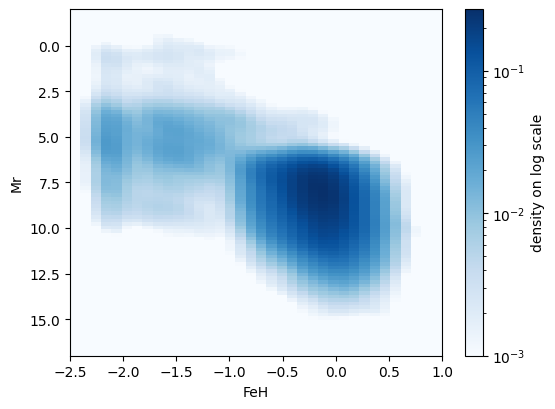

r= 21.0 to 22.0 N= 16321088 Ns= 873408


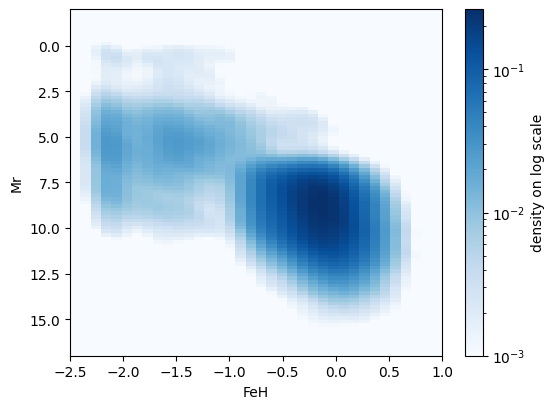

r= 21.5 to 22.5 N= 16321088 Ns= 1042336


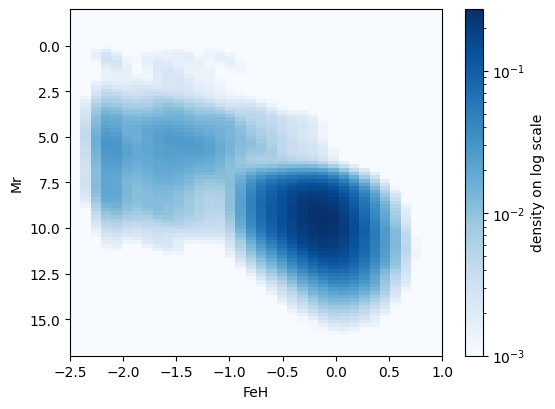

r= 22.0 to 23.0 N= 16321088 Ns= 1253152


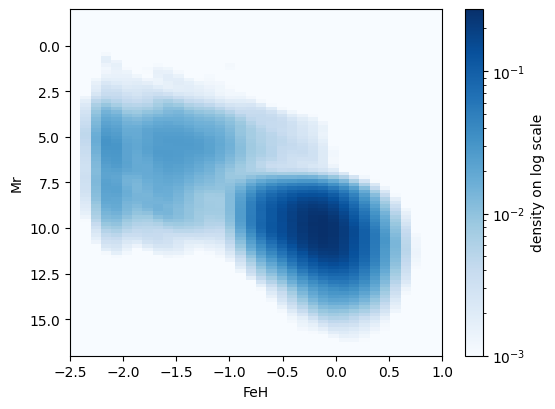

r= 22.5 to 23.5 N= 16321088 Ns= 1501184


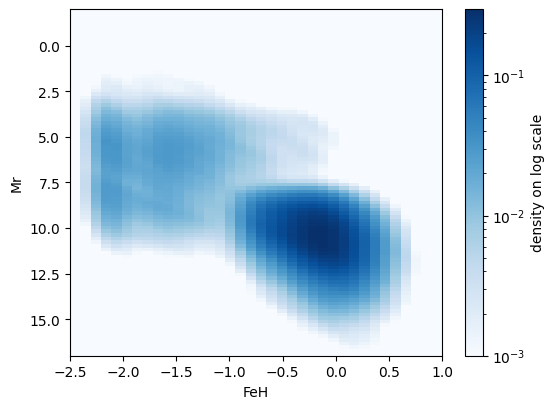

r= 23.0 to 24.0 N= 16321088 Ns= 1788672


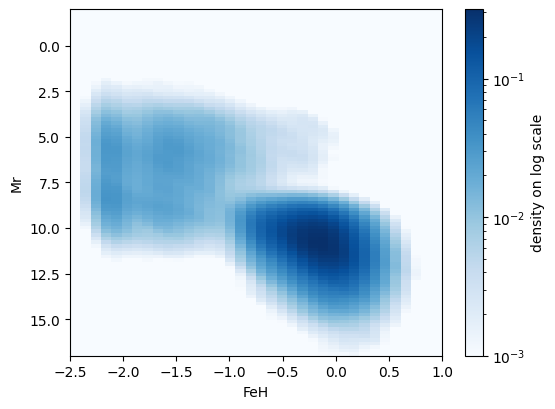

r= 23.5 to 24.5 N= 16321088 Ns= 2089952


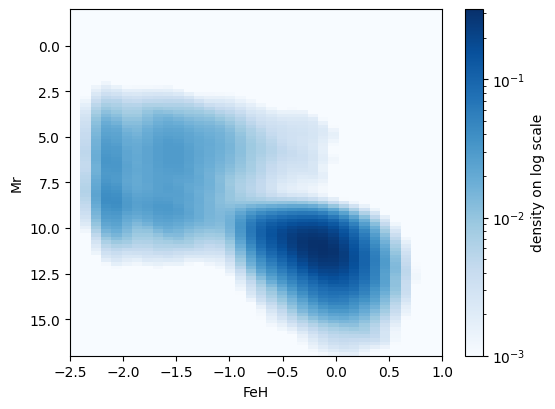

r= 24.0 to 25.0 N= 16321088 Ns= 2371680


In [ ]:
#dump prior maps, replace string with desired location for prior maps
rootname = 'priorsDir/nested12287'
bt.dumpPriorMaps(nested_patch, rootname)